In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import  WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf

pd.set_option("display.max_colwidth", 1000)

In [2]:
df = pd.read_csv("D:/DATA BANGALORE/Data-NLP-Bahasa-Indonesia-main/review_hotel.csv", encoding='latin1')
df.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pelayannya ramah dan banyak membantu. Lokasi cukup dekat ke beberapa obyek wisata. kalau saya ke bandung lagi mungkin saya akan menginap lagi di sini.",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater untuk kopi/teh atau dispenser dan tidak tersedia kursi di depan kamar untuk merokok hingga harus duduk di lantai",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh jdi sarang nyamuk dikamar mandinya...pesan superior double yg dikasih twin...mungkin karena murah saya maklumin, tpi kedepan mohon untuk bisa jdi perbaikan untuk bisa lbh baik lg..",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk tidak diganti,",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


<AxesSubplot:>

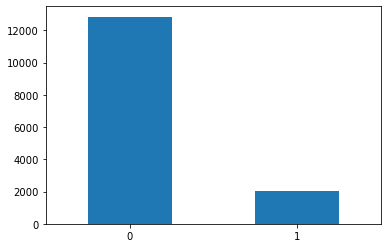

In [3]:
df['category'].value_counts(dropna=False).sort_index().plot(kind='bar', rot='horizontal')

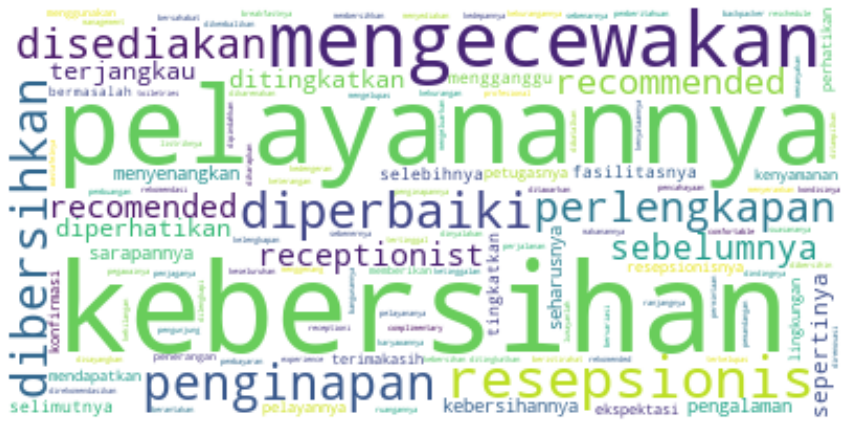

In [4]:
text = " ".join(review for review in df.review_text)
wordcloud = WordCloud(background_color="white", max_words=10000, min_word_length=10).generate(text)
fig=plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [5]:
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)

def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

In [6]:
stemmer = StemmerFactory().create_stemmer()

In [7]:
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    text = stemmer.stem(text)
    return text

In [8]:
df["cleaned_text"] = df["review_text"].apply(preprocess_text)
df.head()

,review_id,review_text,category,cleaned_text
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pelayannya ramah dan banyak membantu. Lokasi cukup dekat ke beberapa obyek wisata. kalau saya ke bandung lagi mungkin saya akan menginap lagi di sini.",1,inap rapi bersih suasana tenang layan ramah dan banyak bantu lokasi cukup dekat ke beberapa obyek wisata kalau saya ke bandung lagi mungkin saya akan inap lagi di sini
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater untuk kopi/teh atau dispenser dan tidak tersedia kursi di depan kamar untuk merokok hingga harus duduk di lantai",0,wifi tidak sampai kamar tidak sedia heater untuk kopi teh atau dispenser dan tidak sedia kursi di depan kamar untuk rokok hingga harus duduk di lantai
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh jdi sarang nyamuk dikamar mandinya...pesan superior double yg dikasih twin...mungkin karena murah saya maklumin, tpi kedepan mohon untuk bisa jdi perbaikan untuk bisa lbh baik lg..",0,lantai kamar mandi kotor bau dan seperti sdh jdi sarang nyamuk kamar mandi pesan superior double yg kasih twin mungkin karena murah saya maklumin tpi depan mohon untuk bisa jdi baik untuk bisa lbh baik lg
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk tidak diganti,",0,wc jorok kasur tidak bersih handuk tidak ganti
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,bocor lagi


In [9]:
target = df["category"]
features_text = df["cleaned_text"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features_text, target, random_state=42)

In [11]:
BATCH_SIZE = 32

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for feat, tar in train_dataset.take(1):
    print(feat[:3])
    print(tar[:3])

tf.Tensor(
[b'lantai kamar mandi dan lanta kamar kurang bersih asa licin'
 b'kamar oke lokasi oke tp sarap kurang enak' b'bad place'], shape=(3,), dtype=string)
tf.Tensor([0 0 0], shape=(3,), dtype=int64)


In [14]:
max_features = 10000     
embedding_dim = 16        

In [15]:
encoder = keras.layers.TextVectorization(max_tokens=max_features)
encoder.adapt(train_dataset.map(lambda feat, tar: feat))

In [16]:
encoder(feat)[:3]

<tf.Tensor: shape=(3, 47), dtype=int64, numpy=
array([[  64,    2,    8,    4, 3730,    2,    7,   10,  322,  556,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   2,  126,   75,  126,   73,   69,    7,  117,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 245,  507,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           

In [17]:
model = keras.Sequential()
model.add(encoder)
model.add(keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()), 
    output_dim=embedding_dim, 
    mask_zero=True))

model.add(keras.layers.LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=["acc"])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          148736    
                                                                 
 lstm (LSTM)                 (None, None, 100)         46800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                        

In [19]:
history = model.fit(train_dataset,
                    epochs=15, batch_size=BATCH_SIZE,
                    validation_data=test_dataset)

Epoch 1/15
349/349 [==============================] - 64s 140ms/step - loss: 0.2747 - acc: 0.9142 - val_loss: 0.1742 - val_acc: 0.9400
Epoch 2/15
349/349 [==============================] - 47s 134ms/step - loss: 0.1857 - acc: 0.9400 - val_loss: 0.1599 - val_acc: 0.9467
Epoch 3/15
349/349 [==============================] - 45s 129ms/step - loss: 0.1717 - acc: 0.9435 - val_loss: 0.1601 - val_acc: 0.9467
Epoch 4/15
349/349 [==============================] - 48s 137ms/step - loss: 0.1620 - acc: 0.9470 - val_loss: 0.1458 - val_acc: 0.9518
Epoch 5/15
349/349 [==============================] - 49s 140ms/step - loss: 0.1587 - acc: 0.9490 - val_loss: 0.1505 - val_acc: 0.9478
Epoch 6/15
349/349 [==============================] - 45s 130ms/step - loss: 0.1541 - acc: 0.9500 - val_loss: 0.1630 - val_acc: 0.9453
Epoch 7/15
349/349 [==============================] - 46s 131ms/step - loss: 0.1498 - acc: 0.9505 - val_loss: 0.1546 - val_acc: 0.9464
Epoch 8/15
349/349 [==============================] - 4

In [20]:
scores = model.evaluate(test_dataset, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("loss: {}".format((scores[0])))

Accuracy: 95.32%
loss: 0.1499941200017929


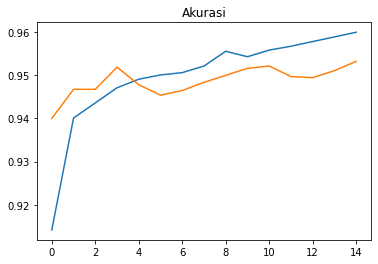

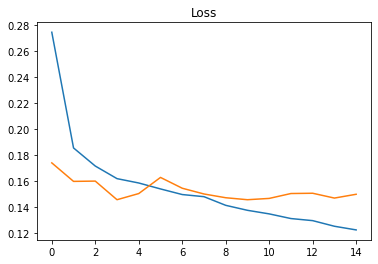

In [21]:
plt.figure()
plt.title("Akurasi")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

plt.figure()
plt.title("Loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.show()

In [22]:
input_review = ["lokasi jauh dari keramaian, kamar mandi sempit dan ac kurang dingin"]
prediksi = model.predict(input_review)
prediksi.squeeze() 
if prediksi.squeeze()>0.5:
    print(prediksi.squeeze())
    print("Review positif")
else:
    print(prediksi.squeeze())
    print("Review negatif")

0.033376694
Review negatif


In [23]:
input_review = ["lokasi dekat dari keramaian, kamar mandi luas dan acnya bagus"]
prediksi = model.predict(input_review) 
prediksi.squeeze() 
if prediksi.squeeze()>0.5:
    print(prediksi.squeeze())
    print("Review positif")
else:
    print(prediksi.squeeze())
    print("Review negatif")

0.9136811
Review positif


In [24]:
model.save_weights('model_weights',save_format='tf')
model.save('model',save_format='tf')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
